# Caliban Fig8 Processing Pipeline

In [1]:
# import statements
from __future__ import absolute_import

import numpy as np
import os
import stat
import sys
import copy


import skimage.io as io
from imageio import imread, volread, imwrite, volwrite
from ipywidgets import fixed, interactive

from caliban_toolbox import reshape_data
from caliban_toolbox.figure_eight_functions import create_figure_eight_job, download_figure_eight_output
from caliban_toolbox.utils import widget_utils, plot_utils, data_utils, io_utils

from segmentation.utils.data_utils import load_imgs_from_dir
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import filters, img_as_uint
perm_mod = stat.S_IRWXO | stat.S_IRWXU | stat.S_IRWXG

## Load data for model training
We'll specify which channels will be used to generate preliminary labels for the model


In [ ]:
# TODO: Universal data loader

In [2]:
# as a placeholder, run the following code to load example data:
channel_data = load_imgs_from_dir("/example_data/timelapse/HeLa_by_image", load_axis="fovs",
                                    imgs=["FITC_001.png", "Phase_000.png", "Phase_001.png", "Phase_002.png"])

In [3]:
# this loads the imaging data into an 4D array of [time, rows, cols, channels]
channel_data.shape

(5, 1080, 1280, 4)

In [4]:
# each channel is labeled according to the image name:
channel_data.channels.values

array(['FITC_001', 'Phase_000', 'Phase_001', 'Phase_002'], dtype='<U9')

In [5]:
# initialize lists to hold newly created channels
adjusted_channels, adjusted_channel_names, adjusted_channel_kwargs = [], [], []

# initialize lists to hold newly created channels
overlay_channels, overlay_channel_names, overlay_channel_kwargs = [], [], []

## Run the data through the network to produce labels

In [6]:
# call deepcell.applications for appropriate model
y_data = data_utils.make_blank_labels(channel_data)

# Part A: Adjust image contrast, background, thresholding

### Step 1: Pick raw image
This will be used as an example to display effect of adjustments later on. This can be changed at any time!

In [7]:
choose_img_output = interactive(widget_utils.choose_img_from_stack, stack = fixed(channel_data), 
                         slice_idx = (0, channel_data.shape[0]-1, 1),
                         chan_name = (channel_data.channels.values));
choose_img_output

interactive(children=(IntSlider(value=2, description='slice_idx', max=4), Dropdown(description='chan_name', op…

### Step 2: Set raw image adjust parameters
These will be held in memory until npz is saved. A record of the contrast adjustment settings will be saved with them.

In [8]:
# get most recent parameters for selected image
selected_slice_idx, selected_channel_idx = choose_img_output.result
img = channel_data[selected_slice_idx, :, :, selected_channel_idx]

# interative edit mode
adjust_image_output = interactive(widget_utils.adjust_image_interactive, image=fixed(img), blur=(0.0,4,0.1), 
                       gamma_adjust=(0.1,4,0.1), sobel_factor=(10,10000,100), v_min = (0, 255, 1), 
                       v_max = (0, 255, 1));
adjust_image_output

interactive(children=(FloatSlider(value=1.0, description='blur', max=4.0), Checkbox(value=True, description='s…

### Step 3: Adjust raw image with specified parameters

In [9]:
# create placeholder channel to hold the output of channel adjustment
adjusted_channel_xr = xr.DataArray(np.zeros(channel_data.shape[:-1] + (1,), np.uint8),
                                   coords=[channel_data.fovs, channel_data.rows, channel_data.cols,
                                          ["adjusted_channel"]],
                                   dims=channel_data.dims)

# adjust all slices for given channel
for i in range(channel_data.shape[0]):
    image = channel_data[i, :, :, selected_channel_idx]
    adjusted_channel_xr[i, :, :, 0] = widget_utils.adjust_image(image, adjust_image_output.kwargs)

### Step 4: Verify that adjustment looks good across slices

In [10]:
check_adjustment_output = interactive(widget_utils.choose_img_from_stack, stack = fixed(adjusted_channel_xr), 
                               slice_idx = (0, channel_data.shape[0]-1, 1),
                              chan_name = fixed("adjusted_channel"));
check_adjustment_output

interactive(children=(IntSlider(value=2, description='slice_idx', max=4), Output()), _dom_classes=('widget-int…

### Step 5: Give the adjusted channel an informative name, repeat part A for each channel that needs to be adjusted

In [11]:
adjusted_channel_name = "Phase_Adjusted"
adjusted_channel_names.append(adjusted_channel_name)
adjusted_channels.append(adjusted_channel_xr.values)
adjusted_channel_kwargs.append(adjust_image_output.kwargs)

# Part B: create overlays

### Step 1: Pick raw image
This will be used as an example to display effect of adjustments later on. This can be changed at any time!

In [12]:
choose_img_output = interactive(widget_utils.choose_img_from_stack, stack = fixed(channel_data), 
                         slice_idx = (0, channel_data.shape[0]-1, 1),
                         chan_name = (channel_data.channels.values));
choose_img_output

interactive(children=(IntSlider(value=2, description='slice_idx', max=4), Dropdown(description='chan_name', op…

### Step 2: Select first channel to be included in overlay, perform any needed adjustments

In [13]:
# available channels
channel_data.channels.values

array(['FITC_001', 'Phase_000', 'Phase_001', 'Phase_002'], dtype='<U9')

In [14]:
img_1_idx = 0
selected_slice_idx, selected_channel_idx = choose_img_output.result
img1 = channel_data[selected_slice_idx, :, :, img_1_idx]

adjust_overlay_1_output = interactive(widget_utils.adjust_image_interactive, image=fixed(img1), blur=(0.0,4,0.1), 
                          gamma_adjust=(0.1,4,0.1), sobel_factor=(10,10000,100), v_min = (0, 255, 1), 
                          v_max = (0, 255, 1));
adjust_overlay_1_output

interactive(children=(FloatSlider(value=1.0, description='blur', max=4.0), Checkbox(value=True, description='s…

### Step 2: Select second channel to be included in overlay, perform any needed adjustments

In [15]:
img_2_idx = 3
img2 = channel_data[selected_slice_idx, :, :, img_2_idx]

adjust_overlay_2_output = interactive(widget_utils.adjust_image_interactive, image=fixed(img2), blur=(0.0,4,0.1), 
                          gamma_adjust=(0.1,4,0.1), sobel_factor=(2,10000,100), v_min = (0, 255, 1), 
                          v_max = (0, 255, 1));
adjust_overlay_2_output

interactive(children=(FloatSlider(value=1.0, description='blur', max=4.0), Checkbox(value=True, description='s…

### Step 3: Select the appropriate settings for combinging the two images together

In [16]:
overlay_images_output = interactive(widget_utils.overlay_images_interactive, 
                               img_1 = fixed(adjust_overlay_1_output.result), 
                               img_2 = fixed(adjust_overlay_2_output.result), 
                               prop_img_1 =(0,1.0, 0.1), v_min = (0, 255, 1), v_max = (0, 255, 1))
overlay_images_output

interactive(children=(FloatSlider(value=0.5, description='prop_img_1', max=1.0), IntSlider(value=0, descriptio…

### Step 4: Create overlays across the whole image stack

In [17]:
# extract settings from interactive job
combined_settings = overlay_images_output.kwargs
prop_img_1 = combined_settings['prop_img_1']
v_min = combined_settings['v_min']
v_max = combined_settings['v_max']

overlay_channel_xr = xr.DataArray(np.zeros(channel_data.shape[:-1] + (1,), np.uint8),
                                   coords=[channel_data.fovs, channel_data.rows, channel_data.cols,
                                          ["overlay_channel"]],
                                   dims=channel_data.dims)

# apply settings across images in stack
for i in range(channel_data.shape[0]):
    image1 = channel_data[i, :, :, img_1_idx]
    image2 = channel_data[i, :, :, img_2_idx]

    image1_adjusted = widget_utils.adjust_image(image1, adjust_overlay_1_output.kwargs)
    image2_adjusted = widget_utils.adjust_image(image2, adjust_overlay_2_output.kwargs)
    overlay_channel_xr[i, :, :, 0] = widget_utils.overlay_images(image1_adjusted, image1_adjusted, 
                                                              prop_img_1, v_min, v_max)

In [18]:
check_adjustment = interactive(widget_utils.choose_img_from_stack, stack = fixed(overlay_channel_xr), 
                         slice_idx = (0, channel_data.shape[0]-1, 1),
                         chan_name = fixed("overlay_channel"));
check_adjustment

interactive(children=(IntSlider(value=2, description='slice_idx', max=4), Output()), _dom_classes=('widget-int…

### Step 5: Give the combined channel an informative name, repeat part B for each set of overlays that needs to be constructed

In [19]:
# give this overlay an informative name
overlay_channel_name = "phase_0_phase_3_overlay"

# add metadata to list
overlay_channel_names.append(overlay_channel_name)
overlay_channels.append(overlay_channel_xr.values)
adjusted_channel_kwargs.append([prop_img_1, v_min, v_max, adjust_overlay_1_output.kwargs, adjust_overlay_2_output])

# Part C: Determine which modified channels will be included and in what order

In [20]:
# concatenate all adjusted channels together
if len(adjusted_channels) > 0:
    adjusted_channel_stack = np.concatenate(adjusted_channels, axis=-1)
else:
    # blank array in case no channels were adjusted
    adjusted_channel_stack = np.array([]).reshape(channel_data.shape[:-1] + (0,))

    
# concatenate all overlayed channels together
if len(overlay_channels) > 0:
    overlay_channel_stack = np.concatenate(overlay_channels, axis=-1)
else:
    # blank array in case no overlays were created
    overlay_channel_stack = np.array([]).reshape(channel_data.shape[:-1] + (0,))

In [21]:
# combine original channels and new channels together
all_channel_stack = np.concatenate((channel_data.values, adjusted_channel_stack, overlay_channel_stack), axis=-1)
all_channel_names = np.concatenate((channel_data.channels.values, 
                                    adjusted_channel_names, overlay_channel_names), axis=0)
all_channel_names

array(['FITC_001', 'Phase_000', 'Phase_001', 'Phase_002',
       'Phase_Adjusted', 'phase_0_phase_3_overlay'], dtype='<U23')

In [22]:
# create labeled xarray to hold all data

# coordinate within each dimension are labeled:
coords = [channel_data.fovs, channel_data.rows, channel_data.cols, all_channel_names]

# each dimension is labeled
dims = ["fovs", "rows", "cols", "channels"] 
all_channels = xr.DataArray(all_channel_stack, coords=coords, dims=dims)

In [23]:
# specify subset of above channels to be incldued, as well as their ordering
channel_order = ["FITC_001", "Phase_000", "Phase_002", "Phase_Adjusted"]

In [24]:
channel_xr = data_utils.reorder_channels(new_channel_order=channel_order, input_data=all_channels)

In [ ]:
# For RGB mode, determine color for each channel. Available options are: red, green, blue, cyan, magenta, yellow
# plot_colors = ["green", "blue"]
# combined_xr = plot_utils.set_channel_colors(channel_data=channel_xr, plot_colors=plot_colors)

# Part D: Set shape of NPZ files for optimum annotator ease

### Crop array into overlapping x and y crops
Split an array up into smaller crops that overlap one another

#### Check crop size
First set parameters to check that crop size and overlap are appropriate

In [25]:
# size of crop
crop_size = (480, 480)

# fraction of crop that will overlap with adjacent crops
overlap_frac = 0.1

# index of channel in npz to visualize
channels_idx = 1

# where crops will get saved
save_dir = "/example_data/timelapse/HeLa_by_image/crop_dir"

In [26]:
# we next add in dimensions of size 1 for any missing dims in input array to bring it up to standard size
X_expanded = data_utils.pad_xr_dims(input_xr=channel_xr)
y_expanded = data_utils.pad_xr_dims(input_xr=y_data)

In [27]:
# we'll test these parameters to see how the crops look
cropped_stack_test, cropped_y_test, log_data_test = reshape_data.crop_multichannel_data(X_data=X_expanded, 
                                                                                        y_data=y_expanded, 
                                                                                        crop_size=crop_size,
                                                                                        overlap_frac=overlap_frac,
                                                                                        test_parameters=True)

In [27]:
# we can also specify crop_num instead of crop_size
cropped_stack_test, cropped_y_test, log_data_test = reshape_data.crop_multichannel_data(X_data=X_expanded, 
                                                                                        y_data=y_expanded, 
                                                                                        crop_num=4,
                                                                                        overlap_frac=overlap_frac,
                                                                                        test_parameters=True)

Next we'll add in line overlays for easier visualization

In [30]:
# extract information about test crop dimensions
row_starts, row_ends  = log_data_test["row_starts"], log_data_test["row_ends"]
col_starts, col_ends = log_data_test["col_starts"], log_data_test["col_ends"]

# get a single crop from the stack of cropped images
example_crop = cropped_stack_test[0, 0, 3, 0, :, :, channels_idx]

# load the first image from the xarray stack, which is the one that the crops were generated from
example_img = copy.deepcopy(X_expanded[0, 0, 0, 0, ...])

In [31]:
example_img_overlay = plot_utils.overlay_grid_lines(overlay_img=example_img[:, :, channels_idx], 
                                                    row_starts=row_starts, row_ends=row_ends, col_starts=col_starts, 
                                                    col_ends=col_ends)

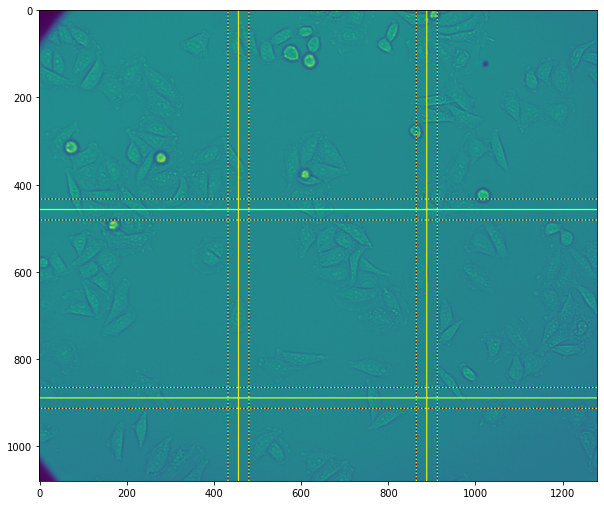

In [32]:
plt.figure(figsize = (10, 10))
plt.imshow(example_img_overlay[:, :])

In [33]:
# generate an overlay of a single crop showing where borders are located
img_crop_overlay = plot_utils.overlay_crop_overlap(img_crop=example_crop.values, row_starts=row_starts,
                                                   row_ends=row_ends, col_starts=col_starts, col_ends=col_ends)

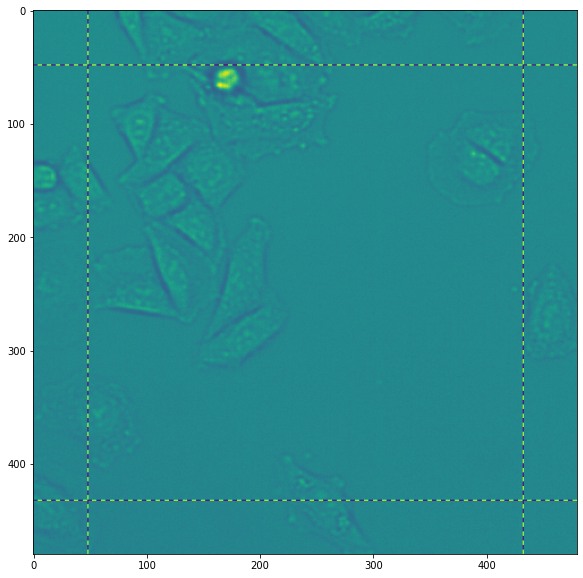

In [34]:
plt.figure(figsize = (10, 10))
plt.imshow(img_crop_overlay)

In [35]:
# once the parameters above look good, we'll crop the images
X_cropped, y_cropped, log_data = reshape_data.crop_multichannel_data(X_data=X_expanded, y_data=y_expanded, 
                                                                     crop_size=crop_size, 
                                                                     overlap_frac=overlap_frac)

In [ ]:
# save cropped data into npz files for upload to Figure8
io_utils.save_npzs_for_caliban(X_data=X_cropped, y_data=y_data, original_data=channel_data, save_dir=save_dir,
                                   log_data=log_data)

## 4. Upload to Figure Eight
Now that the images are processed into subimages, they need to be uploaded to an AWS bucket and submitted to Figure Eight. This involves uploading the files to AWS, making a CSV file with the links to the uploaded images, and using that CSV file to create a Figure Eight job.

In [2]:
base_dir = '/example_data/timelapse/HeLa_by_image/'

In [5]:
# upload cropped data to Figure 8
create_figure_eight_job(base_dir=base_dir, job_id_to_copy=1568089,
                       aws_folder='test/pipeline_test4', stage='from_scratch',rgb_mode=True, pixel_only=True)

Figure eight api key? ········
New job ID is: 1572950
What is your AWS access key id? ········
What is your AWS secret access key id? ········
Connected to AWS
/data/segmentation/figure8_testing/refactor_test3/crop_dir/cHL_Point8908e4f1e7974ba6b9ec6370a12b6678_row_0_col_0.npz  2240450 / 2240450.0  (100.00%)

/data/segmentation/figure8_testing/refactor_test3/crop_dir/cHL_Point8908e4f1e7974ba6b9ec6370a12b6678_row_0_col_1.npz  2240450 / 2240450.0  (100.00%)

Data successfully uploaded to Figure Eight.


## 4. Download from Figure Eight
Now that the images are processed into subimages, they need to be uploaded to an AWS bucket and submitted to Figure Eight. This involves uploading the files to AWS, making a CSV file with the links to the uploaded images, and using that CSV file to create a Figure Eight job.

In [3]:
download_figure_eight_output(base_dir)

Please enter your Figure Eight API key:········
Report saved to folder
What is your AWS access key id? ········
What is your AWS secret access key id? ········
Connected to AWS
